In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from pylab import bone, pcolor, colorbar, plot, show
import matplotlib.lines as mlines

import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [123]:
# This function is not used now
# def calculate_som(df, col_types, target = None, subset = [],grid_size = 10, num_iteration = 1000, sigma = 1.5, learning_rate = 0.5):
#     df = df.copy(deep = True)
#     col_types = col_types.copy()
#     y = None
#     names = None
#     if target != None:
#         y = pd.Categorical(df[target])
#         names = df[target].unique()
#         target_name = target
#         y = y.codes
#         df = df.drop(columns = target)
#         del col_types[target]
    
#     col_types = col_types.copy()
        
#     for column in col_types:
#         if col_types[column] == 'char':
#             df = df.drop(columns  = column)
    
#     if len(subset) > 0 :
#         df = df[subset]
#         print(list(df))
        
                    
#     imputer = SimpleImputer(strategy = 'mean')
#     X = imputer.fit_transform(df)
#     scaler = MinMaxScaler(feature_range = (0,1))
#     X = scaler.fit_transform(X)
#     som = MiniSom(x = grid_size, y = grid_size, input_len = X.shape[1], sigma = sigma, learning_rate = learning_rate,neighborhood_function='gaussian')
#     som.random_weights_init(X)
#     som.train(data = X, num_iteration = num_iteration, verbose = True)
#     return (som, X, y, names, target_name, grid_size)



In [221]:
def _encode_chars(char_values):
    enc_char_values = None   
    for i in range(0, char_values.shape[1]):
        label_encoder = LabelEncoder()
        feature = label_encoder.fit_transform(char_values[:,i])
        feature = feature.reshape(char_values.shape[0], 1)
        onehot_encoder = OneHotEncoder(sparse = False, categories = 'auto')
        feature = onehot_encoder.fit_transform(feature)
        if enc_char_values is None:
            enc_char_values = feature
        else:
            enc_char_values = np.concatenate((enc_char_values, feature), axis = 1)
            
    return enc_char_values

In [10]:
def find_unique(df, col_types, output_folder = None):

    top_unique = df.nunique() / df.shape[0] * 100
    top_unique = top_unique[top_unique > 90]
    df_unique = pd.DataFrame(top_unique, columns = ['Percentage of unique values'])
    if output_folder is not None:
        dfi.export(df_unique, f'{output_folder}/table_top_unique.png')  
    
    return df_unique    

In [11]:
def calculate_som_v2(df, col_types, target = None, use_char_cols = False, subset = None,
                     grid_size = 10, num_iterations = 1000,  sigma = 1.5, learning_rate = 0.5):
    target_name = target
    names = df[target].unique()
    df = df.copy(deep = True).dropna()
    y = pd.Categorical(df[target]) #target variable that will be plotted on graphs
    df = df.drop(columns = target)

    if subset is not None:
        df = df[subset]
    
    if use_char_cols == True:
        num_X = df.select_dtypes(exclude = 'object').values
        scaler = MinMaxScaler(feature_range = (0,1))
        num_X = scaler.fit_transform(num_X)
        unique_columns = None
        unique_columns = find_unique(df, col_types).index.tolist() #this method is called to check wheter there are characterical columns with more than 90% unique values
        for element in unique_columns:                    
                unique_columns.remove(element)
        df = df.drop(columns = unique_columns)
                    
        char_X = df.select_dtypes(include = 'object').values
        char_X_enc = _encode_chars(char_X)

        X = np.concatenate((num_X, char_X_enc), axis = 1)
    else:
        X = df.select_dtypes(exclude = 'object').values
        scaler = MinMaxScaler(feature_range = (0,1))
        X = scaler.fit_transform(X)
    
    som = MiniSom(x = grid_size, y = grid_size, input_len = X.shape[1], sigma = sigma, learning_rate = learning_rate,
                  neighborhood_function= 'gaussian')
    som.pca_weights_init(X) #for better performance pca weights are initialized instead of random weights
    som.train(X, num_iterations , verbose=True)
    
    return (som, X, y, names, target_name, grid_size) # returned set is later used in plotting functions
        

In [3]:
def som_across_vars(df, col_types, columns, target = None, grid_size = 10, num_iterations = 100000):
    
    for column in columns:
        X = df[column].values.reshape(-1,1)
        print(X.shape)
        if col_types[column] == 'char':
            continue
            # to be added
        som = MiniSom(x = grid_size, y = grid_size, input_len = X.shape[1])
        # som.random_weights_init(X)
        som.train(X, num_iterations, verbose = True)
        
        plt.rcParams["figure.figsize"] = (10,12)
        bone()
        pcolor(som.distance_map().T)
        plt.title(column)
        plt.show()

In [4]:
iris_cols = {"sepal.length" : 'num',
             "sepal.width" : 'num',
             "petal.length" : 'num',
             "petal.width" : 'num',
             "variety" : 'char'}
iris = pd.read_csv('Datasets/iris.csv', sep = ',')

(150, 1)
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.00012892779415731563


c:\Users\PF25LP\Anaconda3\lib\site-packages\minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


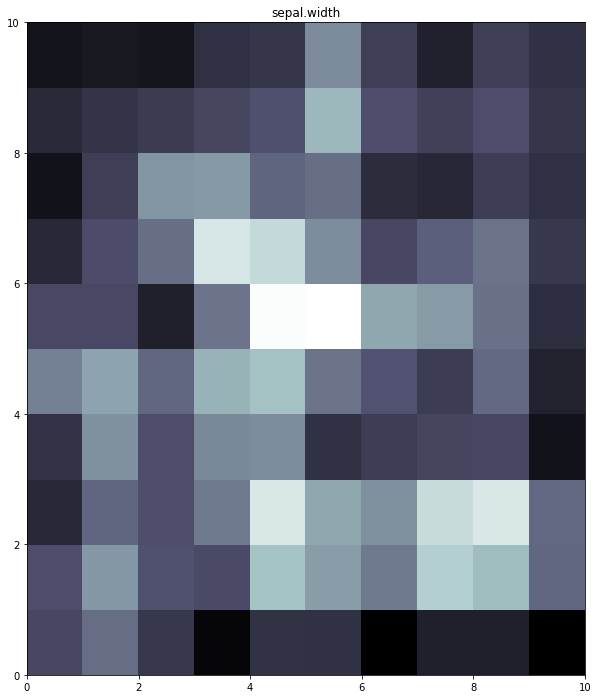

(150, 1)
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 4.214004536936739e-05


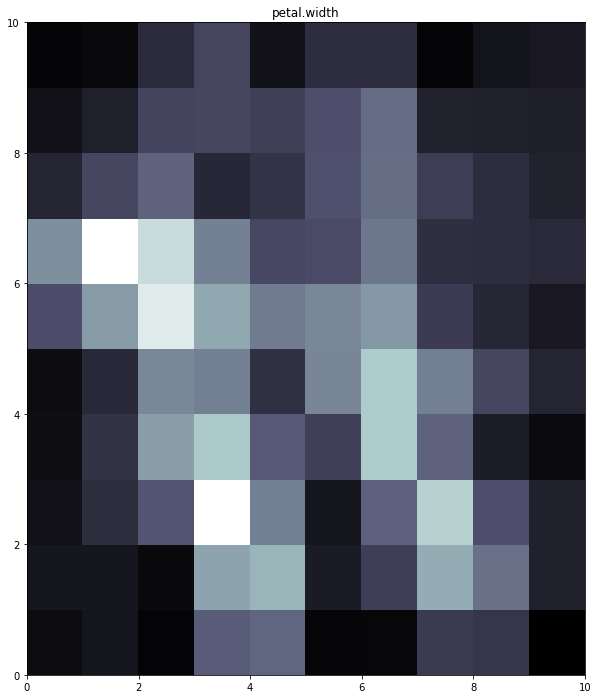

(150, 1)
(150, 1)
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.0038985346090415172


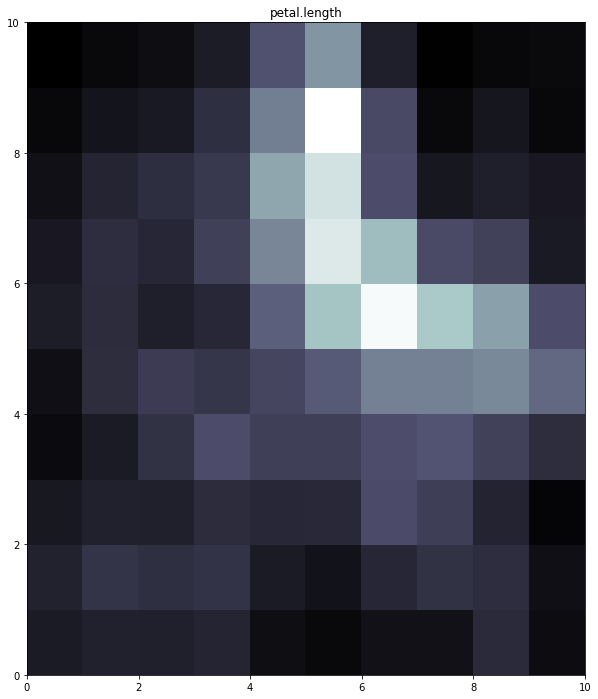

In [5]:
som_across_vars(iris, iris_cols, ['sepal.width', 'petal.width', 'variety', 'petal.length'])

In [6]:
def plot_som_scatter(calculate_som):
    w_x, w_y = zip(*[calculate_som[0].winner(d) for d in calculate_som[1]])
    w_x = np.array(w_x)
    w_y = np.array(w_y)

    plt.figure(figsize=(10, 9))
    plt.pcolor(calculate_som[0].distance_map().T, cmap='Oranges', alpha=.2)
    plt.colorbar()

    for c in calculate_som[3]:
        idx_target = calculate_som[2]==c
        plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                    w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                    s=50, label = c)
    plt.legend(loc='upper right', title = calculate_som[4] + ':') 

In [124]:
def plot_som_squares(calculate_som):
    plt.rcParams["figure.figsize"] = (10,12)
    bone()
    pcolor(calculate_som[0].distance_map().T)
    colorbar(location = 'bottom', pad = 0.05)
    if calculate_som[2] is not None:
        colors = []
        markers_legend = []
        for cat in range(0,len(np.unique(calculate_som[2])), 1):
            r, g, b = np.random.uniform(0, 1, 3)
            colors.append((r, g, b, 1))
            markers_legend.append(mlines.Line2D([], [],
                                                linestyle= "None" ,
                                                markerfacecolor = 'None',
                                                markeredgecolor = colors[cat], 
                                                marker = 's', markersize = 10,
                                                markeredgewidth = 1.5,
                                                label = f'{calculate_som[3][cat]}'))
        
        markers = ['s'] * len(np.unique(calculate_som[2]))

        for i, x in enumerate(calculate_som[1]):
            w = calculate_som[0].winner(x)
            plot(w[0] + 0.5,
                w[1] + 0.5,
                's',
                markeredgecolor = colors[calculate_som[2][i]],
                markerfacecolor = 'None',
                markersize = 10,
                markeredgewidth = 1.5)
    
    
        plt.legend(handles = markers_legend, loc='center left', bbox_to_anchor=(1,0.5))
    
    plt.show()


In [5]:
def plot_som_counts(calculate_som):
    label_names = calculate_som[2].unique()
    labels_map = calculate_som[0].labels_map(calculate_som[1], calculate_som[2])
    fig= plt.figure(figsize=(9, 9))
    fig.set_facecolor('w')
    the_grid = gridspec.GridSpec(x[5], x[5], fig)
    for position in labels_map.keys():
        label_fracs = [labels_map[position][l] for l in label_names]
        plt.subplot(the_grid[x[5]-1-position[1],
                            position[0]], aspect=1)
        patches, texts = plt.pie(label_fracs)

    fig.legend(patches, label_names, bbox_to_anchor = (1,1) ,ncol=1)
    plt.show()

In [6]:
def plot_som_freq(calculate_som):
    plt.figure(figsize=(10, 10))
    frequencies = calculate_som[0].activation_response(calculate_som[1])
    plt.pcolor(frequencies.T, cmap='Blues') 
    plt.colorbar()
    plt.show()

In [7]:
def som_clusters(df, col_types, n_clusters = 2, num_iteration = 1000):
    col_types = col_types.copy()
    df = df.copy(deep = True)
    for column in col_types:
        if col_types[column] == 'char':
            df = df.drop(columns  = column)
                
    imputer = SimpleImputer(strategy = 'mean')
    X = imputer.fit_transform(df)
    scaler = MinMaxScaler(feature_range = (0,1))
    X = scaler.fit_transform(X)
    
    df = pd.DataFrame(X, columns=list(df))
    som_shape = (1, n_clusters)
    som = MiniSom(x = som_shape[0], y = som_shape[1], input_len = X.shape[1], sigma = 0.7, learning_rate = 0.5, neighborhood_function = 'gaussian')
    som.train_random(X, num_iteration = num_iteration, verbose = True)
    winner_coordinates = np.array([som.winner(x) for x in X]).T
    cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)
    return (cluster_index, X, som, df)



In [8]:
def plot_som_clusters(som_clusters, var1 = None, var2= None):
    plt.rcParams["figure.figsize"] = (10,10)
    axes = (var1, var2) 
    for c in np.unique(som_clusters[0]):
        plt.scatter(som_clusters[3][axes[0]][som_clusters[0] == c],
                    som_clusters[3][axes[1]][som_clusters[0] == c], label='cluster '+str(c), alpha=.5)

    names = list(som_clusters[3])
    c1 = names.index(var1)
    c2 = names.index(var2)
    for centroid in som_clusters[2].get_weights():
        plt.scatter(centroid[:, c1], centroid[:, c2], marker='x', 
                    s = 5, linewidths=10, color='k', label='centroids')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
    plt.show()



In [12]:
    cols_adult = {
        'age': 'num', 
        'workclass': 'char', 
        'fnlwgt': 'num', 
        'education': 'char', 
        'education_num': 'num',
        'marital_status': 'char', 
        'occupation': 'char', 
        'relationship': 'char', 
        'race': 'char', 
        'sex': 'char',
        'capital_gain': 'num', 
        'capital_loss': 'num', 
        'hours_per_week': 'num', 
        'native_country': 'char',
        'income': 'char'}
    adult = pd.read_csv('Datasets/adult.csv', sep = ';', na_values = ['?', np.nan, '??'])

In [13]:
iris_cols = {"sepal.length" : 'num',
             "sepal.width" : 'num',
             "petal.length" : 'num',
             "petal.width" : 'num',
             "variety" : 'num'}
iris = pd.read_csv('Datasets/iris.csv', sep = ',')

In [166]:
x = calculate_som_v2(iris, iris_cols, target = 'variety', num_iterations=10000)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.047812057965674996


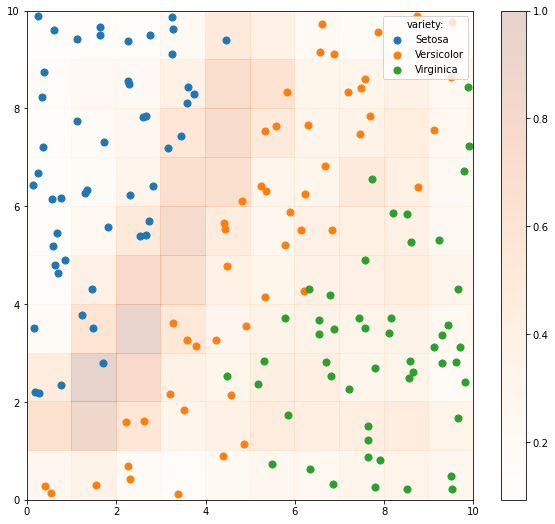

In [167]:
plot_som_scatter(x)

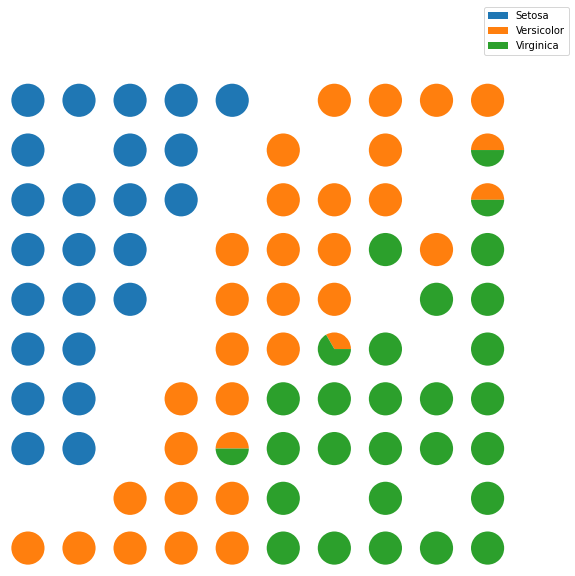

In [168]:
plot_som_counts(x)

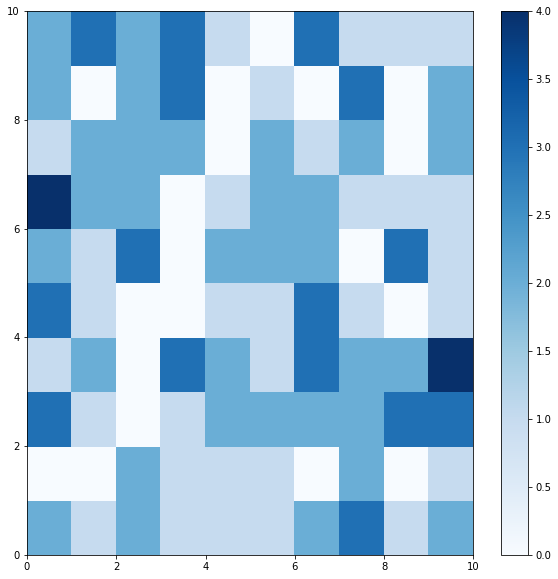

In [169]:
plot_som_freq(x)

In [160]:
cols_wine = {
    'fixed acidity' : 'num',
    'volatile acidity' : 'num',
    'citric acid' : 'num',
    'residual sugar' : 'num',
    'chlorides' : 'num',
    'free sulfur dioxide' : 'num',
    'total sulfur dioxide' : 'num',
    'density' : 'num',
    'pH' : 'num',
    'sulphates' : 'num',
    'alcohol' : 'num',
    'quality' : 'char'
}
wine = pd.read_csv('Datasets/wine.csv', sep = ',', na_values=[np.nan])

In [76]:
wine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [161]:
wine_subset = wine[wine['quality'].isin([4,8,3])]

In [164]:
x = calculate_som_v2(wine_subset, cols_wine, target = 'quality', num_iterations= 100000, grid_size= 5)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.2776941859845358


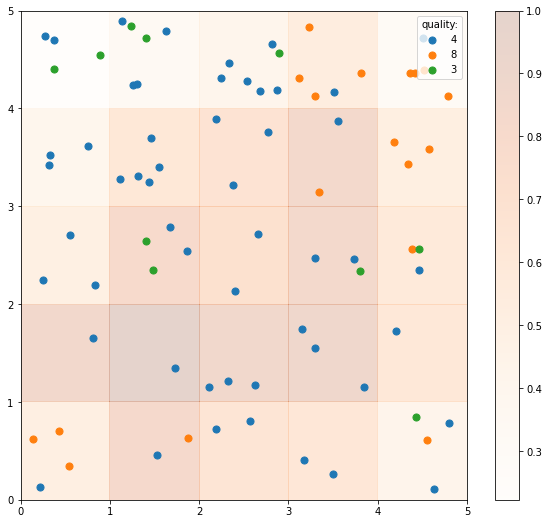

In [165]:
plot_som_scatter(x)